In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import yfinance as yf
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import accuracy_score,log_loss, precision_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
symbol = '^GDAXI' # German Dax stock market index
# Downloading Symbol history
start = pd.datetime(2010,1,1) # Year, Month, Day
end = pd.datetime.now() # Until today date
data = yf.download(symbol, start=start, end=end, progress=False)[['High','Low']].round(2)

In [3]:
data.head() # Frist 5 rows of the dataset

,High,Low
Date,,
2010-01-04,6048.30,5974.43
2010-01-05,6058.02,6015.67
2010-01-06,6047.57,5997.09
2010-01-07,6037.57,5961.25
2010-01-08,6053.04,5972.24


In [4]:
# Calculate Intraday High minus Low, Daily difference (positive/negative)
data['H-L'] = data.High - data.Low
# HL_Sign check if tomorrow daily range(H-L) is greater the today daily range (H-L).will use it as a target cell in the ML test. 
data['HL_Sign'] = np.where(data['H-L'].shift(-1) > data['H-L'],1,-1)

data.dropna(inplace=True)
data.head()

,High,Low,H-L,HL_Sign
Date,,,,
2010-01-04,6048.30,5974.43,73.87,-1
2010-01-05,6058.02,6015.67,42.35,1
2010-01-06,6047.57,5997.09,50.48,1
2010-01-07,6037.57,5961.25,76.32,1
2010-01-08,6053.04,5972.24,80.80,-1


In [5]:
# Creating new 5-lag columns with lag (for Daily (High-Low) difference from day to day) to be in the same line  
lags = 5
cols = []
for lag in range(0, lags):
    col = 'lag_%s' % lag
    data[col] = data['H-L'].shift(lag)
    cols.append(col)

data.dropna(inplace=True)
data.head()

,High,Low,H-L,HL_Sign,lag_0,lag_1,lag_2,lag_3,lag_4
Date,,,,,,,,,
2010-01-08,6053.04,5972.24,80.80,-1,80.80,76.32,50.48,42.35,73.87
2010-01-11,6094.26,6031.14,63.12,1,63.12,80.80,76.32,50.48,42.35
2010-01-12,6055.56,5924.72,130.84,-1,130.84,63.12,80.80,76.32,50.48
2010-01-13,5974.44,5925.24,49.20,1,49.20,130.84,63.12,80.80,76.32
2010-01-14,6009.91,5951.69,58.22,1,58.22,49.20,130.84,63.12,80.80


In [6]:
# Standardization features with subtraction of the mean and then dividing by its standard deviation
scale = StandardScaler()
data[cols] =scale.fit_transform(data[cols])

In [7]:
# Split the dataset to X(features) and y(target) before assigning the train and test data.  
X = data[cols]
y = data['HL_Sign']

In [8]:
# Split the data to train/test. We will train 0.7  * length and test our Classifier on the rest (the test data). 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [9]:
# Create a model dictionary (model_dic) with keys as diffrent ML Classifiers. 
model_dic = {}

# fitting the model and getting the score insample for train data
model_dic['Svm'] = [svm.SVC(gamma='scale').fit(X_train,y_train).score(X_test,y_test),
                    svm.SVC(gamma='scale').fit(X_train,y_train).predict(X_test)]

model_dic['Logistic Regression'] = [LogisticRegression(solver='lbfgs').fit(X_train,y_train).score(X_test,y_test),
                                   LogisticRegression(solver='lbfgs').fit(X_train,y_train).predict(X_test)]

model_dic['Random Forest'] = [RandomForestClassifier(n_estimators=100).fit(X_train,y_train).score(X_test,y_test),
                              RandomForestClassifier(n_estimators=100).fit(X_train,y_train).predict(X_test)]

model_dic['Gradient Boosting'] = [GradientBoostingClassifier().fit(X_train,y_train).score(X_test,y_test),
                                  GradientBoostingClassifier().fit(X_train,y_train).predict(X_test)]

model_dic['Gaussian NB'] =  [GaussianNB().fit(X_train,y_train).score(X_test,y_test),
                             GaussianNB().fit(X_train,y_train).predict(X_test)]

model_dic['K-Neighbors'] =  [KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train).score(X_test,y_test),
                             KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train).predict(X_test)]

In [10]:
#Creating a new dataset (ml_result) with the dictionary(model_dic) inside,transpose and highlight results of best/worst clasifier
ml_result = pd.DataFrame.from_dict(model_dic, orient='index', columns=['Accuracy Score', 'prd'])
ml_result.drop('prd',axis=1, inplace=True)
ml_result = ml_result.T.round(3)
ml_result.style.highlight_max(color='lightgreen', axis=1).highlight_min(color='#cd4f39', axis=1)

,Svm,Logistic Regression,Random Forest,Gradient Boosting,Gaussian NB,K-Neighbors
Accuracy Score,0.722,0.739,0.741,0.73,0.637,0.704


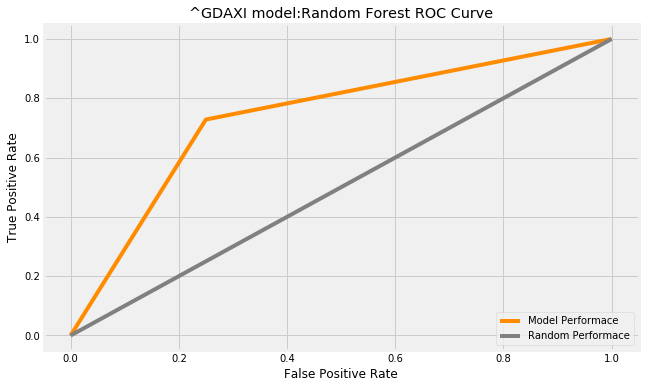

In [11]:
best_model = max(model_dic.keys(), key=lambda k: model_dic[k])
fpr, tpr, thresholds = roc_curve(y_test, model_dic[best_model][1])

# plotting the FPR (false positive rate) vs the TPR (true positive rate) at various thresholds settings (ROC Curve)
# for the best model

fig, ax = plt.subplots(1, figsize=(9.5, 6))
plt.plot(fpr, tpr, color='darkorange', label='Model Performace')
plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} model:{best_model} ROC Curve')
plt.legend(loc="lower right");

## Feature importance

In [12]:
rf = RandomForestClassifier(n_estimators=50, max_depth=4).fit(X_train,y_train)
rf.score(X_test, y_test)

0.739247311827957

In [13]:
features_importens = list(zip(cols,rf.feature_importances_))
features_importens.sort(key=lambda tup: tup[1], reverse=True)
features_importens


[('lag_0', 0.6909693830264195),
 ('lag_1', 0.08889440168526258),
 ('lag_4', 0.0768198063336875),
 ('lag_2', 0.0725816599238798),
 ('lag_3', 0.07073474903075062)]

## K-fold cross-validation

CV mean: 0.709


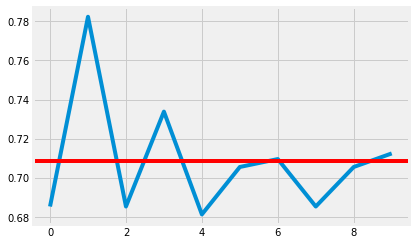

In [14]:
fold_pref = []

kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier(n_estimators=50, max_depth=4)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    fold_pref.append(acc_score)
    
plt.plot(fold_pref);
plt.axhline(np.mean(fold_pref), color='r');
print('CV mean:', np.round(np.mean(fold_pref),3))